<a href="https://colab.research.google.com/github/SRARNAB7/HDS_5230_07_Arnab/blob/main/Facial_Vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
zip_path = "/content/archive (1).zip"
extract_path= "/content"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

print(f"Files Extracted to:{extract_path}")

Files Extracted to:/content


In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Input,Dense, Dropout
from keras.layers import Flatten,Conv2D,MaxPooling2D,BatchNormalization



In [3]:
train_dir = "/content/train"
test_dir = "/content/test"

In [4]:
image_size=(48,48)
batch_size=64       #key hyperparameter, it refers to the no of training examples used in 1 iteration of updating the models weight
epochs=50

In [5]:
def count_images(dir):
  total_images= 0

  for sub_dir,_,files in os.walk(dir):
    total_images += len(files)

  return total_images

train_images= count_images(train_dir)
test_images= count_images(test_dir)

print(f"Total Training Images:{train_images}")
print(f"Total Testing Images:{test_images}")

Total Training Images:28709
Total Testing Images:7178


In [6]:
def count_images_per_dir(dir):

  for sub_dir,_,files in os.walk(dir):
    total_images = len(files)
    print(f"{sub_dir} contents:{total_images}")

print("Training set images count in each folder")
count_images_per_dir(train_dir)

print("Testing set images count in each folder")
count_images_per_dir(test_dir)


Training set images count in each folder
/content/train contents:0
/content/train/fear contents:4097
/content/train/neutral contents:4965
/content/train/surprise contents:3171
/content/train/angry contents:3995
/content/train/sad contents:4830
/content/train/happy contents:7215
/content/train/disgust contents:436
Testing set images count in each folder
/content/test contents:0
/content/test/fear contents:1024
/content/test/neutral contents:1233
/content/test/surprise contents:831
/content/test/angry contents:958
/content/test/sad contents:1247
/content/test/happy contents:1774
/content/test/disgust contents:111


In [7]:
#data augumentation for training
train_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
   # width_shift_range=0.2,
   # height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
test_datagen= ImageDataGenerator(rescale=1./255) # 255 color combination

In [9]:
train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'grayscale',
    shuffle=True
)

Found 28709 images belonging to 7 classes.


In [12]:
test_generator= train_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'grayscale',
    shuffle= False
)

Found 7178 images belonging to 7 classes.


Data print from the folders with labesl label code sample image with type and code class code 6 label photo print VGG16 model


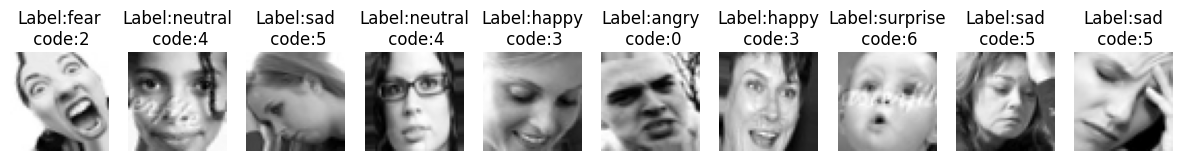

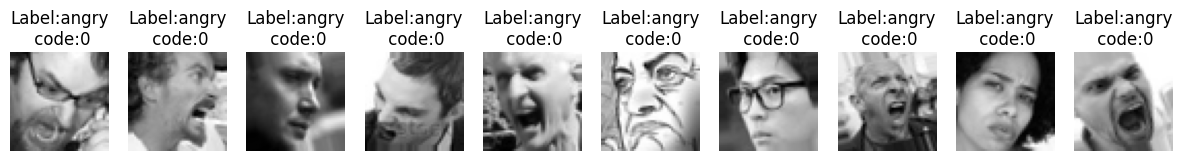

In [13]:
def plot_sample_data(generator,number_samples=10):
  images,labels= next(generator)

  class_indices= generator.class_indices
  #print("Class Indices:",class_indices)
  class_names= list(class_indices.keys())
  #print("Class Names:",class_names)

  plt.figure(figsize=(15,15))

  for i in range(number_samples):
    plt.subplot(1,number_samples,i+1)
    plt.imshow(images[i].reshape(image_size[0],image_size[1]),cmap='grey') # first convert then give color
    label_index= np.argmax(labels[i]) # argmax func returns indices of the max element of the array
    #print(label_index)
    label_name= class_names[label_index]
    plt.title(f'Label:{label_name}\n code:{label_index}')
    plt.axis('off')
  plt.show()

plot_sample_data(train_generator)
plot_sample_data(test_generator)



In [14]:
from keras.optimizers import Adam
#Define Model
base_model= VGG19(weights='imagenet', include_top= False, input_shape= (48,48,3))# in one channel since in gral scale only
#Adding custom layers on top
input_tensor= Input(shape= (48,48,1))
layers=Conv2D(3,(1,1),padding='same')(input_tensor)
layers= Model(inputs= input_tensor,outputs=layers)(input_tensor)
base_model_output= base_model(layers)
layers= base_model_output
layers= GlobalAveragePooling2D()(layers)
layers= Dense(512,activation='relu')(layers) # 256 no of neurons, relu for non linear
layers= BatchNormalization()(layers)
layers= Dropout(0.5)(layers)
layers= Dense(256,activation='relu')(layers) # 256 no of neurons, relu for non linear
layers= BatchNormalization()(layers)
layers= Dropout(0.5)(layers)
predictions = Dense(7,activation='softmax')(layers) #7 neurons since 7 class and softmax when multiclass classification

model_vgg19= Model(inputs=input_tensor,outputs=predictions)
for layer in base_model.layers[:-4]:
  layer.trainable=False

model_vgg19.compile(optimizer= Adam(learning_rate= 0.0001),loss= 'categorical_crossentropy', metrics= ['accuracy'])
model_vgg19.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 48, 48, 3)           │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,423,245 (77.91 MB)

 Trainable params: 7,476,749 (28.52 MB)

 Non-trainable params: 12,946,496 (49.39 MB)

In [15]:
history_vgg19= model_vgg19.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // batch_size,
    validation_data=  test_generator,
    validation_steps = test_generator.samples // batch_size,
    epochs = 50
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.1872 - loss: 2.8320 - val_accuracy: 0.1819 - val_loss: 2.6886
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.2344 - loss: 2.4951

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2344 - loss: 2.4951 - val_accuracy: 0.1832 - val_loss: 2.6571
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.2604 - loss: 2.3111 - val_accuracy: 0.3345 - val_loss: 1.8711
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3438 - loss: 2.0064 - val_accuracy: 0.3341 - val_loss: 1.8878
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.3007 - loss: 2.0833 - val_accuracy: 0.2301 - val_loss: 2.4284
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2969 - loss: 2.0757 - val_accuracy: 0.2349 - val_loss: 2.3993
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.3279 - loss: 1.9317 - val_accuracy: 0.3468 - val_loss: 1.7941
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2812 - loss: 2.2207 - val_accuracy: 0.3485 - val_loss: 1.8067
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.3575 - loss: 1.8091 - val_accuracy: 0

In [16]:
model_vgg19.save('/content/my_model_vgg19.h5')

In [17]:
test_loss, test_accuracy = model_vgg19.evaluate(test_generator)
print(f'Test Accuracy:{test_accuracy*100:.2f}%')
print(f'Test Loss:{test_loss*100:.2f}%')

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4295 - loss: 1.5321
Test Accuracy:49.62%
Test Loss:136.10%


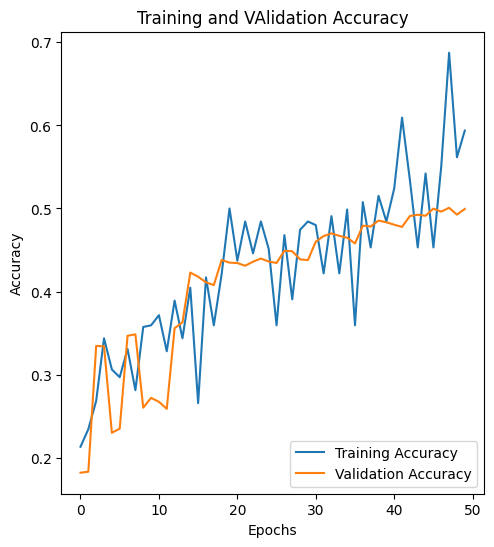

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_vgg19.history['accuracy'],label= 'Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Training and VAlidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')